In [1]:
import matplotlib.pyplot as plt
from core.Classifier import Classifier
from core.Util import *
import xlrd
import scipy
import joblib
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import json


In [3]:
#LENDO A BASE DO RAIDO
book = xlrd.open_workbook('Classificação Raido v1.xlsx')
sheets = book.sheet_names()
d1 = []
cont = 0
MAX = len(sheets)-11
with tqdm(total=MAX) as pbar:
    for sheet in range(0,len(sheets)):
        sheet = sheets[sheet]
        data = book.sheet_by_name(sheet)
        query = data.row(1)[2].value
        q  = {'query':query,
             'documents':[]}
        for i in range(4,data.nrows):
            #Verifico se o ultimo campo está vazio
            _id = i-3
            title = data.row(i)[0].value.replace('\r','').replace('\n','').lower()
            file = data.row(i)[5].value
            label = data.row(i)[10].value.replace('\r','').replace('\n','').replace(' ','').lower()


            obs = data.row(i)[11].value
            url = data.row(i)[14].value
            _id = cont
            if len(title) > 0: 
                if label: 
                    cont+=1
                    doc = {
                        'title':title,
                        'file':file,
                        'url':url,
                        'label':label,
                        'obs':obs,
#                         'words':TextCounter(title),
#                         'vet' : [],
#                         'lang' : analiser(title)
                    }
                    q['documents'].append(doc)
        d1.append(q)
        pbar.update(1)

                
# book = xlrd.open_workbook('bibliografia-janaina.xlsx')
# sheets = book.sheet_names()
# d2 = []
# cont = 0
# for sheet in range(len(sheets)-2):
#     sheet = sheets[sheet] 
#     data = book.sheet_by_name(sheet)
#     for i in range(4,data.nrows):
#         title = data.row(i)[1].value.replace('\r','').replace('\n','').lower()
#         id = cont
#         cont+=1
#         doc = {
#             'title':title,
#             'words':TextCounter(title),
#             'vet' : []
#         }
#         if title: 
#             d2.append(doc)

24it [00:00, 360.05it/s]              


In [ ]:
print(d1)

In [4]:
for i in d1:
    aux = i['query'].replace(' ','-')
    with open('/dados/querys-classificadas/{}.json'.format(aux),'w') as f:
        json.dump(i,f,indent=4,sort_keys=True)


with open('data-raido.json','w') as f:
    json.dump(d1,f,indent=4,sort_keys=True)

# with open('data-janaina.json','w') as f:
#     json.dump(d2,f,indent=4,sort_keys=True)

In [26]:
from joblib import Parallel, delayed
MAX = len(d1)

#Paraleliso a análise da lingua e o filtro
aux = Parallel(n_jobs=16)(delayed(analiser)(d1[i]['title']) for i in range(MAX))
for i in range(len(d1)):    
    d1[i]['lang'] = aux[i]
aux = Parallel(n_jobs=16)(delayed(filtering)(d1[i]['title'],d1[i]['lang']) for i in range(MAX))

for i in range(len(d1)):    
    d1[i]['text'] = aux[i]


End: 48.30621886253357


In [4]:
dicionario = {}

with tqdm(total=MAX) as pbar:
    for i in range(len(d1)):    
        if d1[i]['text']:
            for j in range(len(d1[i]['text'])):
                if d1[i]['text'][j] in dicionario:
                    dicionario[d1[i]['text'][j]] +=1
                else:
                    dicionario[d1[i]['text'][j]] =1
        pbar.update(1)
        
aux_dic = [(i,dicionario[i]) for i in dicionario]
aux_dic = sorted(aux_dic, key=lambda tup: tup[1],reverse=True)

100%|██████████| 1041/1041 [00:00<00:00, 88747.14it/s]


Os 50 termos mais frequentes!


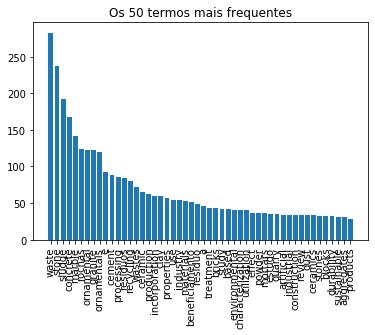

In [5]:
print('Os 50 termos mais frequentes!')
x = [ i[0] for i in aux_dic[:50]]
y = [ i[1] for i in aux_dic[:50]]
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title('Os 50 termos mais frequentes')
plt.show()

Os 50 termos menos frequentes!


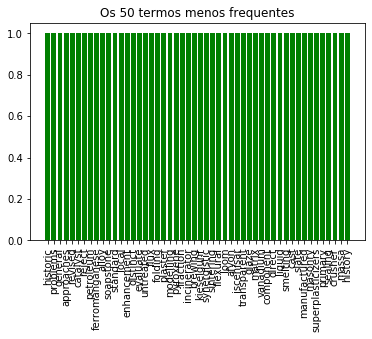

In [6]:
print('Os 50 termos menos frequentes!')
x = [ i[0] for i in aux_dic[-50:]]
y = [ i[1] for i in aux_dic[-50:]]
plt.bar(x,y,color='g')
plt.xticks(rotation=90)
plt.title('Os 50 termos menos frequentes')
plt.show()

TF-IF
('especiais', 6.932447891572509)
('vítreos', 6.932447891572509)
('revisão', 6.932447891572509)
('bibliográfica', 6.932447891572509)
('estudos', 6.932447891572509)
('arte', 6.932447891572509)
('cerâmicas', 6.932447891572509)
('alternativ', 6.932447891572509)
('vidrados', 6.932447891572509)
('aditivos', 6.932447891572509)
('fundentes', 6.932447891572509)
('colorantes', 6.932447891572509)
('residuos', 6.932447891572509)
('para', 6.932447891572509)
('producao', 6.932447891572509)
('vitreos', 6.932447891572509)
('substituição', 6.932447891572509)
('parcial', 6.932447891572509)
('produto', 6.932447891572509)
('quartizito', 6.932447891572509)
('seridó', 6.932447891572509)
('mitigação', 6.932447891572509)
('racional', 6.932447891572509)
('originária', 6.932447891572509)
('centro', 6.932447891572509)
('ctr', 6.932447891572509)
('vitrocerâmicos', 6.932447891572509)
('alta', 6.932447891572509)
('metais', 6.932447891572509)
('obtidos', 6.932447891572509)
('enchimento', 6.932447891572509)
('a

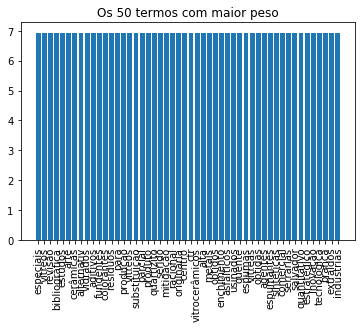

In [7]:
print('TF-IF')

for i in range(len(d1)):
    if d1[i]['text']:
        d1[i]['tf'] = TF_Dic(' '.join(d1[i]['text']))
    
t1 = [d1[i]['tf'] for i in range(len(d1)) if d1[i]['text']]
idf_dic = IDF_Dic(t1)
# tf_idf_dic = TF_IDF_Dic(t1)
# print(tf_idf_dic)
aux = [ (i,idf_dic[i]) for i in idf_dic]
aux = sorted(aux, key=lambda tup: tup[1],reverse=True)

for i in aux[:50]:
    print(i)

print('Os 50 termos com maior peso!')
x = [ i[0] for i in aux[:50]]
y = [ i[1] for i in aux[:50]]
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title('Os 50 termos com maior peso')
plt.show()

In [4]:
print('Distribuição das classes!')
classes = {}
for i in d1:
    c = i['label']
    if c in classes:
        classes[c] +=1
    else:
        classes[c] =1

c_labels = [(i,classes[i]) for i in classes]

print(c_labels)

Distribuição das classes!
[('sim', 646), ('não', 393), ('não', 1), ('', 1)]
